In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [2]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./open/sample_submission.csv')

# 전처리에 활용 되는 기본 적인 함수

In [3]:
# day를 year로 변경해주는 함수
def days_to_year(x):
    return (x*-1)/365

In [4]:
# 마이너스 변환
def minus(x):
    return x * -1

# 이상치 제거
다른 변수들을 기준으로 이상치를 제거 하였을 때는 의미가 없었지만
child_num을 기준으로 값의 차이가 많이 나는 경우에만 제거 해주었습니다.

In [5]:
def remove_outlier(train, column):
    
    df = train[column]
    
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    print(df.iloc[outlier_index])
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [6]:
candidate = ['child_num']
for cand in candidate:  
    train = remove_outlier(train,cand)

train.reset_index(drop = True,inplace = True)
len(train)

outlier의 수 :  6
8462     14
9021     14
10731    19
25313     7
25390    14
25638     7
Name: child_num, dtype: int64


26451

# 변수 조합으로 추가 변수(object) 생성하기

In [7]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].astype(str) + "_" + data['income_total'].astype(str) + "_" + data['income_type'].astype(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].astype(str) + "_" + data['income_total'].astype(str) + "_" + data['income_type'].astype(str) + "_" + data['begin_month'].astype(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
    
    return data

In [8]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [9]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log1p)

    # DAYS_EMPLOYED 변수 전처리
    # 0 이상인 경우 0으로 모두 변환
    data.loc[data['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    # day를 year로 변환
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_year) 
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].apply(np.log1p)

    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_year)

    #  DAYS_BIRTH, DAYS_EMPLOYED, income_total변수를 조합하여 RATIO 변수 생성
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # 가족수 - 자식수
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
    # 가족수와 자녀수 sum 변수 추가
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수 및 자식 수로 나눈 비율
    data['INCOME_FAM_RATIO'] = data['income_total']/data['family_size']
    data['INCOME_child_num_RATIO'] = data['income_total']/data['child_num']
    
    # 일을하게 된 시점 변수 추가
    data['BIRTH_MINUS_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    # income total 변수에 before_EMPLOYED로 나눈 변수 추가
    data['INCOME_BIRTH_MINUS_EMPLOYED_RATIO'] = data['income_total']/data['BIRTH_MINUS_EMPLOYED']
    
    return data 

In [10]:
train = numeric_process(train)
test = numeric_process(test)

# occyp_type 변수 전처리

In [11]:
def occype_process(data):
    
    # occyp_type 변수에만 있는 결측치를 'NAN' 값으로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    print(data['occyp_type'].value_counts(), '\n\n')

    return data


In [12]:
train = occype_process(train)
test = occype_process(test)

Laborers                 4512
no_work                  4438
NAN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1572
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            401
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      123
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64 


Laborers                 1699
no_work                  1697
NAN                      1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleani

# 구간화 변수 생성

In [13]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable], '\n\n')
    
    return data

In [14]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음
train = make_bin(train, 'DAYS_BIRTH', n=10)
test = make_bin(test, 'DAYS_BIRTH', n=10)

0        0
1        1
2        2
3        3
4        3
        ..
26446    1
26447    3
26448    5
26449    5
26450    2
Name: DAYS_BIRTH_bin, Length: 26451, dtype: int64 


0       0
1       1
2       2
3       1
4       3
       ..
9995    1
9996    8
9997    4
9998    3
9999    9
Name: DAYS_BIRTH_bin, Length: 10000, dtype: int64 




# 성능이 저하되는 불필요 변수 제거

In [15]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

# 최종 데이터 shape 확인
test의 경우 label이 없으므로 train 변수 갯수의 -1

In [16]:
train.shape, test.shape

((26451, 33), (10000, 32))

# 학습을 위한 피쳐 레이블 및 label 생성

In [17]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

# 전체 변수 정보 확인

In [18]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             26451 non-null  object 
 1   car                                26451 non-null  object 
 2   reality                            26451 non-null  object 
 3   child_num                          26451 non-null  int64  
 4   income_type                        26451 non-null  object 
 5   edu_type                           26451 non-null  object 
 6   family_type                        26451 non-null  object 
 7   house_type                         26451 non-null  object 
 8   DAYS_BIRTH                         26451 non-null  float64
 9   work_phone                         26451 non-null  int64  
 10  phone                              26451 non-null  int64  
 11  email                              26451 non-null  int

# 컬럼 순서대로 정렬 후 object형 변수의 인덱스 정보를 cat_feature에 활용

In [19]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin_id', 'g_r_c', 'p_w_e']
[ 0  1  2  4  5  6  7 12 15 16 17 18]


# 모델 학습

In [20]:
cat_models={}

def cat_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            # val 데이터 예측
            predictions = cat.predict_proba(X_val)
            # test 데이터 예측
            test_predictions = cat.predict_proba(test)

            # val 데이터 예측 logloss 값 저장
            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            # test 데이터 예측 결과 종합
            # 최종 적으로는 kolds 횟수 만큼 나눠서 평균 값을 활용
            sub+=test_predictions

            print(f'================================================================================\n\n')

    # 저장된 val 데이터 예측 logloss 값의 평균 값으로 성능을 비교
    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    
    return sub/(folds.n_splits * len(random_seed))
    

In [21]:
my_submission = cat_kfold(8, 0.04, [1042])

====================================1============================================
0:	learn: 1.0753981	test: 1.0753981	test1: 1.0756713	best: 1.0756713 (0)	total: 172ms	remaining: 8m 36s
100:	learn: 0.7193150	test: 0.5183206	test1: 0.6833848	best: 0.6833848 (100)	total: 9.9s	remaining: 4m 44s
200:	learn: 0.7043177	test: 0.4936565	test1: 0.6754033	best: 0.6754033 (200)	total: 22.5s	remaining: 5m 13s
300:	learn: 0.6885788	test: 0.4764666	test1: 0.6723342	best: 0.6723342 (300)	total: 35.9s	remaining: 5m 21s
400:	learn: 0.6738639	test: 0.4705566	test1: 0.6711357	best: 0.6711357 (400)	total: 49.5s	remaining: 5m 20s
500:	learn: 0.6590802	test: 0.4663528	test1: 0.6707385	best: 0.6706953 (496)	total: 1m 4s	remaining: 5m 19s
600:	learn: 0.6420648	test: 0.4609411	test1: 0.6705789	best: 0.6703244 (574)	total: 1m 17s	remaining: 5m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6703244328
bestIteration = 574

Shrink model to first 575 iterations.
FOLD 1 : logloss:0.6703244328

700:	learn: 0.6301748	test: 0.4490891	test1: 0.6651684	best: 0.6651349 (696)	total: 1m 40s	remaining: 5m 30s
800:	learn: 0.6159579	test: 0.4446388	test1: 0.6647183	best: 0.6645502 (787)	total: 1m 55s	remaining: 5m 17s
900:	learn: 0.6010922	test: 0.4407893	test1: 0.6642516	best: 0.6642253 (861)	total: 2m 10s	remaining: 5m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6642252852
bestIteration = 861

Shrink model to first 862 iterations.
FOLD 9 : logloss:0.6642252851534052


====================================10============================================
0:	learn: 1.0768180	test: 1.0767707	test1: 1.0768660	best: 1.0768660 (0)	total: 150ms	remaining: 7m 30s
100:	learn: 0.7181306	test: 0.5172599	test1: 0.6810804	best: 0.6810804 (100)	total: 11.8s	remaining: 5m 37s
200:	learn: 0.7022428	test: 0.4922048	test1: 0.6743342	best: 0.6742762 (191)	total: 25.2s	remaining: 5m 50s
300:	learn: 0.6881953	test: 0.4752019	test1: 0.6722590	best: 0.6722526 (299)	total: 40.2s	remai

# Feature_Importance_Plot

In [22]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

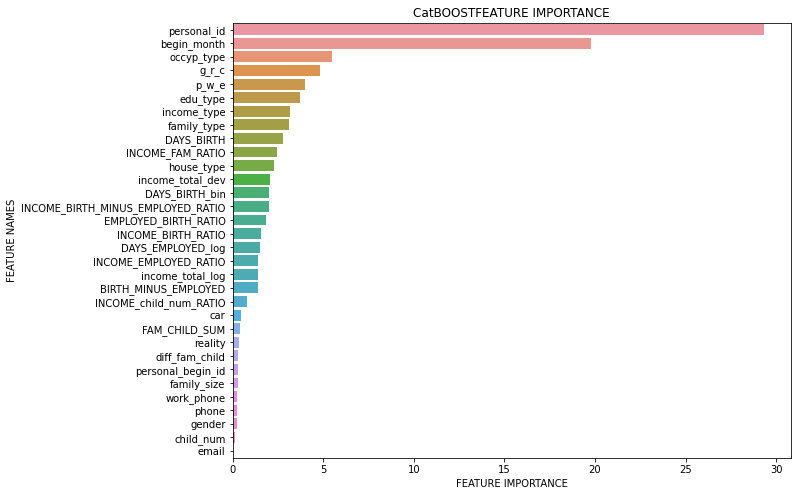

In [23]:
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# train 데이터 전체로 fit하여 학습한 것을 최종 모델로 활용
- AutoML 에서 최종적으로 finalize로 학습시키는 것처럼 최종 파라미터로 전체 데이터에 fit하여 학습시켰습니다.

In [24]:
cat = CatBoostClassifier(n_estimators=443, max_depth=8, random_seed=2, learning_rate =0.04, bootstrap_type ='Bernoulli')
cat.fit(train_x, train_y, cat_features=cat_features, verbose=50)
test_predictions = cat.predict_proba(test)

0:	learn: 1.0757624	total: 123ms	remaining: 54.5s
50:	learn: 0.7395179	total: 4.71s	remaining: 36.2s
100:	learn: 0.7122598	total: 10.8s	remaining: 36.7s
150:	learn: 0.7035743	total: 17.4s	remaining: 33.6s
200:	learn: 0.6971476	total: 24.7s	remaining: 29.7s
250:	learn: 0.6911508	total: 31.5s	remaining: 24.1s
300:	learn: 0.6834176	total: 38.7s	remaining: 18.3s
350:	learn: 0.6765608	total: 45.9s	remaining: 12s
400:	learn: 0.6692687	total: 53.1s	remaining: 5.56s
442:	learn: 0.6642179	total: 59s	remaining: 0us


# 결과 확인 및 제출 파일 생성

In [25]:
my_submission = test_predictions 
my_submission

array([[0.13829551, 0.17505449, 0.68665   ],
       [0.3400513 , 0.23890038, 0.42104832],
       [0.03970559, 0.075411  , 0.88488341],
       ...,
       [0.04644717, 0.11143624, 0.84211659],
       [0.14229699, 0.31695901, 0.540744  ],
       [0.05513677, 0.44792195, 0.49694128]])

In [26]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.138296,0.175054,0.686650
1,26458,0.340051,0.238900,0.421048
2,26459,0.039706,0.075411,0.884883
3,26460,0.064676,0.072748,0.862576
4,26461,0.077521,0.208858,0.713621
...,...,...,...,...
9995,36452,0.062775,0.207264,0.729960
9996,36453,0.132797,0.431556,0.435647
9997,36454,0.046447,0.111436,0.842117
9998,36455,0.142297,0.316959,0.540744


In [27]:
submission.to_csv('./submit/10fold_cat_0.66575_fit_443_0.6642179_(2).csv', index=False) 

In [28]:
submission.head(20)

,index,0,1,2
0,26457,0.138296,0.175054,0.686650
1,26458,0.340051,0.238900,0.421048
2,26459,0.039706,0.075411,0.884883
3,26460,0.064676,0.072748,0.862576
4,26461,0.077521,0.208858,0.713621
5,26462,0.056017,0.125721,0.818262
6,26463,0.651822,0.325448,0.022729
7,26464,0.044295,0.084168,0.871537
8,26465,0.055915,0.082178,0.861907
9,26466,0.058975,0.273207,0.667817
